# orders_dataset

### Key Columns:
- *order_purchase_delivered_days*
- *order_estimated_actual_delivered_days*

### Foreign Keys:
- *order_id* -> **orders_dataset** NOT UNIQUE VALUES IN THE FOREIGN KEY!!! (**92 425** UNIQUE AFTER PREPROCESSING out of 92 919 -> **group_by** [mean of latitude and longitude] or drop_duplicates)

### Key Findings:
- *order_approved_at*, *order_delivered_carrier_date*, *order_delivered_customer_date* have missing values
- missing values in *order_delivered_customer_date* are due to the *order_status* being not delivered, we drop them all and then remove the column *order_status* as it would only have values **delivered** in this column
- *order_purchase_delivered_days* and *order_estimated_actual_delivered_days* have quite strong linear correlation
- it is clearly visible that the correlation between the two features is high. This is expected since the *order_purchase_delivered_days* is calculated based on the *order_delivered_customer_date* and *order_purchase_timestamp*. Therefore, it is recommended to use only one of these features in the model. In this case, the *order_purchase_delivered_days* feature is more informative since it shows the actual time between the purchase and delivery of the order
- *order_purchase_delivered_days* and *order_estimated_actual_delivered_days* are still somewhat skewed

### Preprocessing Steps:

- remove all records that refer to *order_status* different than **delivered** but if that was supposed to be a column with only one value, then it can be dropped
- new column: *order_purchase_delivered_days* (*order_delivered_customer_date* - *order_purchase_timestamp*)
- new column: *order_estimated_actual_days* (*order_delivered_customer_date* - *order_estimated_delivery_date*): **if the value is negative then the delivery was earlier than planned, if it is positive, then there was a delay**
- remove outliers from newly created columns

### Issues & Clarifications:
- foreign key: *order_id* does not have unique values

$10.23\%$ of data has been removed.

## EDA

In [ ]:
from utils import check_functions, visuals, cleaning, preprocessing, feature_engineering

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_colwidth', None)

In [ ]:
orders_dataset = pd.read_csv('../data/raw/orders_dataset.csv')
orders_dataset

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,delivered,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,delivered,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,delivered,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,delivered,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15 00:00:00


In [4]:
orders_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [5]:
check_functions.missing_values(orders_dataset)

,Column,Missing Values
0,order_id,0
1,customer_id,0
2,order_status,0
3,order_purchase_timestamp,0
4,order_approved_at,160
5,order_delivered_carrier_date,1783
6,order_delivered_customer_date,2965
7,order_estimated_delivery_date,0


In [6]:
check_functions.nunique_values(orders_dataset)

,Column,Nunique,Unique Values
0,order_id,99441,Too Much
1,customer_id,99441,Too Much
2,order_status,8,"[delivered, invoiced, shipped, processing, unavailable, canceled, created, approved]"
3,order_purchase_timestamp,98875,Too Much
4,order_approved_at,90733,Too Much
5,order_delivered_carrier_date,81018,Too Much
6,order_delivered_customer_date,95664,Too Much
7,order_estimated_delivery_date,459,Too Much


In [7]:
check_functions.duplicates(orders_dataset)

There are no duplicates.


In [8]:
numerical_summary, object_summary = check_functions.summarize(orders_dataset)

In [9]:
numerical_summary

,count,unique,top,freq
order_id,99441,99441,e481f51cbdc54678b7cc49136f2d6af7,1
customer_id,99441,99441,9ef432eb6251297304e76186b10a928d,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-04-11 10:48:14,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2018-05-08 23:38:46,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


In [10]:
object_summary

,count,unique,top,freq
order_id,99441,99441,e481f51cbdc54678b7cc49136f2d6af7,1
customer_id,99441,99441,9ef432eb6251297304e76186b10a928d,1
order_status,99441,8,delivered,96478
order_purchase_timestamp,99441,98875,2018-04-11 10:48:14,3
order_approved_at,99281,90733,2018-02-27 04:31:10,9
order_delivered_carrier_date,97658,81018,2018-05-09 15:48:00,47
order_delivered_customer_date,96476,95664,2018-05-08 23:38:46,3
order_estimated_delivery_date,99441,459,2017-12-20 00:00:00,522


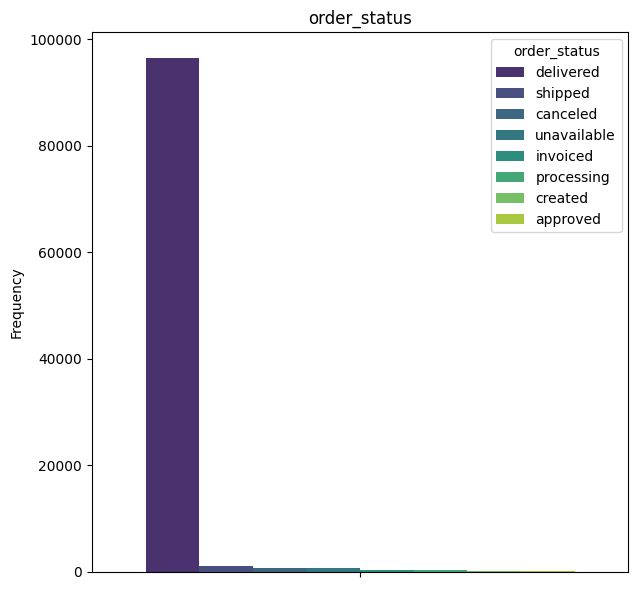

In [11]:
visuals.barplots(orders_dataset, ['order_status'])

In [12]:
orders_dataset[orders_dataset['order_delivered_customer_date'].isna()]["order_status"].value_counts()

order_status
shipped        1107
canceled        619
unavailable     609
invoiced        314
processing      301
delivered         8
created           5
approved          2
Name: count, dtype: int64

Missing values in *order_delivered_customer_date* are due to the *order_status* being not delivered, we drop them all and then remove the column *order_status* as it would only have values **delivered** in this column.

We can further explore the dataset after cleaning it up and constructing new features.

## Data Cleaning & Feature Engineering

1. Remove all records that refer to *order_status* different than **delivered** but if that was supposed to be a column with only one value, then it can be dropped.
2. New column: *order_purchase_delivered_days* (*order_delivered_customer_date* - *order_purchase_timestamp*).
3. New column: *order_estimated_actual_days* (*order_delivered_customer_date* - *order_estimated_delivery_date*): **if the value is negative then the delivery was earlier than planned, if it is positive, then there was a delay**.

In [15]:
pipeline = make_pipeline(
    cleaning.DropNaRows(["order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date"]),
    cleaning.DropColumnTransformer(["order_status"]),
    preprocessing.DataTypeTransformer({"order_purchase_timestamp": 'datetime64', 
                                       "order_approved_at": 'datetime64', 
                                       "order_delivered_carrier_date": 'datetime64', 
                                       "order_estimated_delivery_date": 'datetime64',
                                       "order_delivered_customer_date": 'datetime64'}),
    feature_engineering.FeatureAdder("order_purchase_delivered_days", 
                                     lambda X: (X["order_delivered_customer_date"] - X["order_purchase_timestamp"]).dt.total_seconds() / 86400 ),
    feature_engineering.FeatureAdder("order_estimated_actual_delivered_days", 
                                     lambda X: (X["order_delivered_customer_date"] - X["order_estimated_delivery_date"]).dt.total_seconds() / 86400 )
)

In [16]:
orders_dataset_final = pipeline.fit_transform(orders_dataset)
orders_dataset_final

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_delivered_days,order_estimated_actual_delivered_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574,-7.107488
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.782037,-5.355729
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.394213,-17.245498
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.208750,-12.980069
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.873877,-9.238171
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,-10.369433
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.193727,-1.265324
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.859421,-5.524803
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.086424,-20.018819


$3\%$ of data was removed during the process.

In [18]:
check_functions.outliers(orders_dataset_final, ['order_purchase_delivered_days', 'order_estimated_actual_delivered_days'])

,Outlier Count,Outlier Percentage (%)
Column,,
order_purchase_delivered_days,4898,5.077700
order_estimated_actual_delivered_days,4874,5.052819


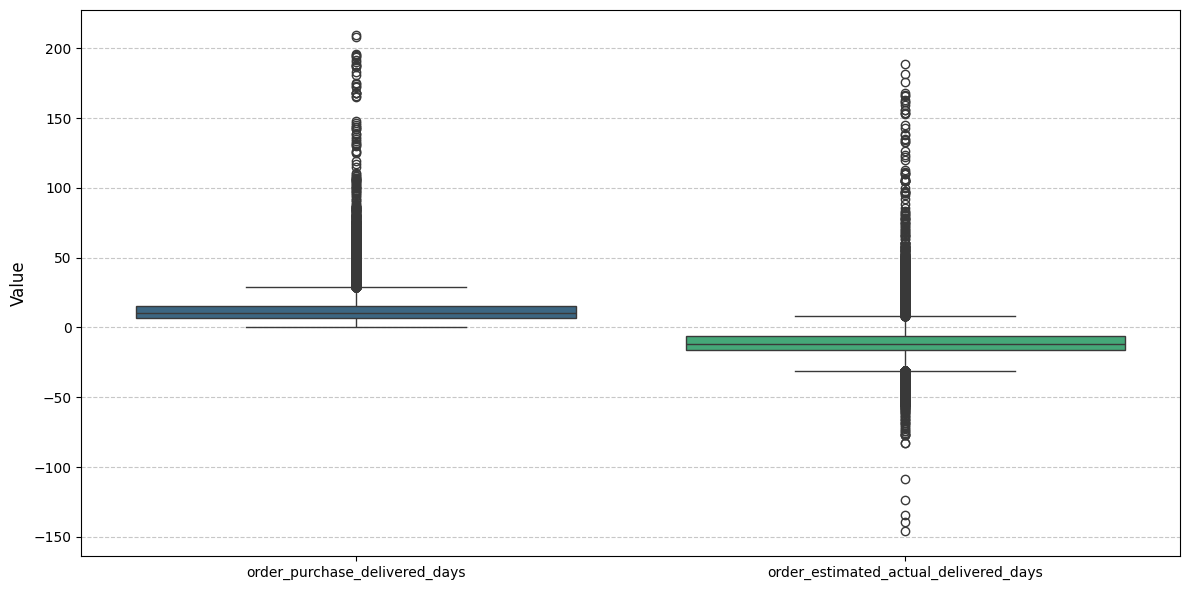

In [28]:
visuals.boxplots(orders_dataset_final, ['order_purchase_delivered_days', 'order_estimated_actual_delivered_days'])

We can still remove duplicates after the transformations.

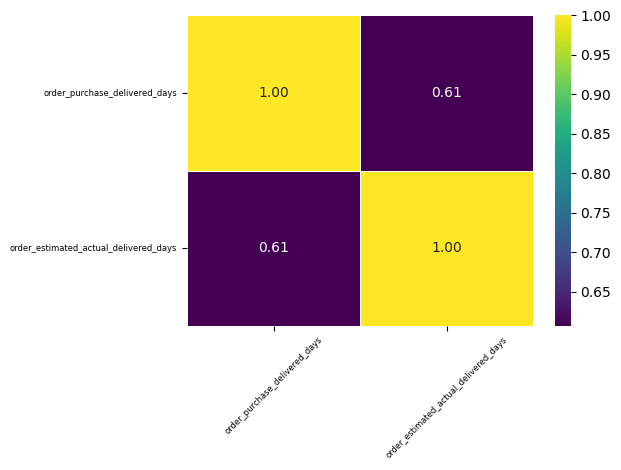

In [20]:
visuals.correlations(orders_dataset_final, ['order_purchase_delivered_days', 'order_estimated_actual_delivered_days'])

*order_purchase_delivered_days* and *order_estimated_actual_delivered_days* have quite strong linear correlation.

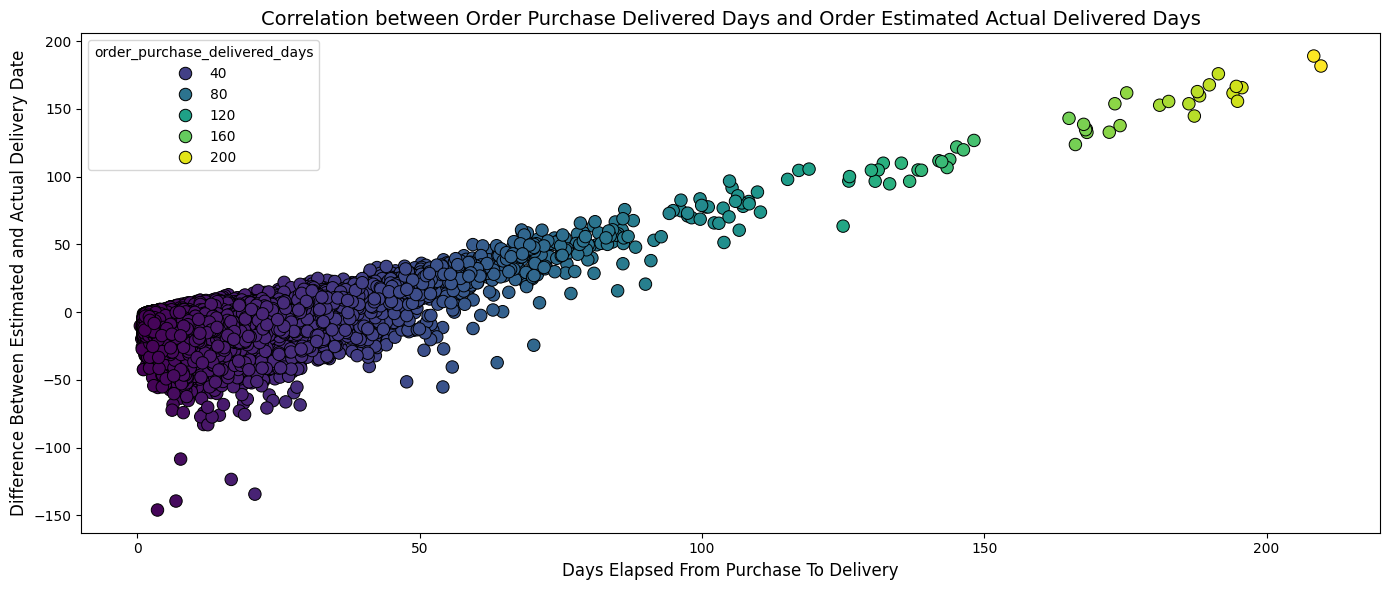

In [25]:
plt.figure(figsize=(14, 6))
sns.scatterplot(data=orders_dataset_final,
                x='order_purchase_delivered_days',
                y='order_estimated_actual_delivered_days',
                hue='order_purchase_delivered_days',
                palette='viridis',
                s=80,
                edgecolor='black')
plt.title('Correlation between Order Purchase Delivered Days and Order Estimated Actual Delivered Days', fontsize=14)
plt.xlabel('Days Elapsed From Purchase To Delivery', fontsize=12)
plt.ylabel('Difference Between Estimated and Actual Delivery Date', fontsize=12)
plt.tight_layout()
plt.show()

It is clearly visible that the correlation between the two features is high. This is expected since the *order_purchase_delivered_days* is calculated based on the *order_delivered_customer_date* and *order_purchase_timestamp*. Therefore, it is recommended to use only one of these features in the model. In this case, the *order_purchase_delivered_days* feature is more informative since it shows the actual time between the purchase and delivery of the order.

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))
c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


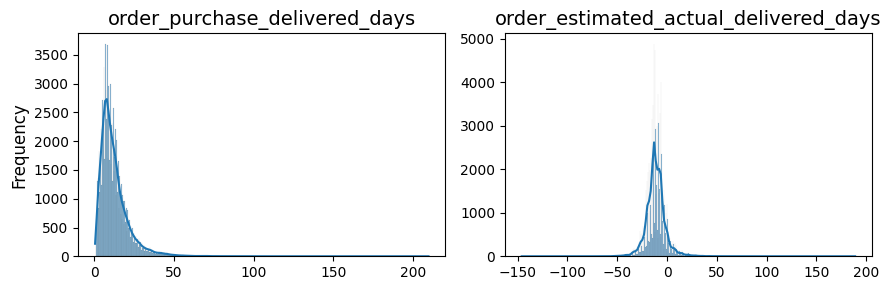

In [27]:
visuals.histograms(orders_dataset_final, ['order_purchase_delivered_days', 'order_estimated_actual_delivered_days'])

In [29]:
orders_dataset_final_final = cleaning.OutlierRemover_IQR(['order_purchase_delivered_days', 'order_estimated_actual_delivered_days']).fit_transform(orders_dataset_final)
orders_dataset_final_final

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,order_purchase_delivered_days,order_estimated_actual_delivered_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,8.436574,-7.107488
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,13.782037,-5.355729
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,9.394213,-17.245498
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,13.208750,-12.980069
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,2.873877,-9.238171
...,...,...,...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28,8.218009,-10.369433
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02,22.193727,-1.265324
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27,24.859421,-5.524803
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-12 15:35:03,2018-01-25 23:32:54,2018-02-15,17.086424,-20.018819


In general, about $10.23\%$ of data is dropped.

c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))
c:\Users\jk200\Desktop\Ehhh\Coding\Machine Learning\Project2\eda\eda_utils\visuals.py:55: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(data=dataset, x=column, kde=True, ax=axes[i], palette=sns.color_palette("viridis", as_cmap=True))


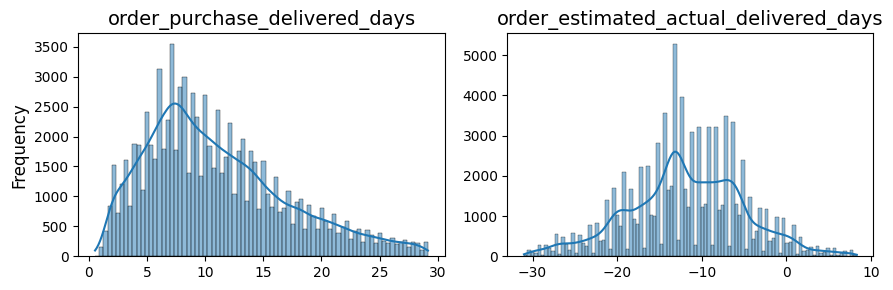

In [32]:
visuals.histograms(orders_dataset_final_final, ['order_purchase_delivered_days', 'order_estimated_actual_delivered_days'])

Finally, looking better, still maybe can work on the distribution.

In [ ]:
# orders_dataset_final_final.to_csv("../data/after/orders_dataset_done.csv")